In [1]:
# watermark the notebook
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import sys
import tensorflow.keras
import scipy as sp
import tensorflow as tf
import platform
import numpy as np
import matplotlib.pyplot as plt

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")

gpus = tf.config.list_physical_devices('GPU')
print("GPU Resources Available:\n\t",gpus)

# getting rid of the warning messages about optimizer graph
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)


Python Platform: macOS-13.2.1-arm64-arm-64bit
Tensor Flow Version: 2.9.0
Keras Version: 2.9.0

Python 3.9.16 (main, Jan 11 2023, 10:02:19) 
[Clang 14.0.6 ]
GPU Resources Available:
	 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Generating images

This notebook was heavily manipualted from the second code sample found in Chapter 8, Section 4 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

Dr. Larson unified this example with the example from tensorflow: https://www.tensorflow.org/tutorials/generative/cvae

---


## Variational autoencoders


Variational autoencoders, simultaneously discovered by Kingma & Welling in December 2013, and Rezende, Mohamed & Wierstra in January 2014, 
are a kind of generative model that is especially appropriate for the task of image editing via concept vectors. They are a modern take on 
autoencoders -- a type of network that aims to "encode" an input to a low-dimensional latent space then "decode" it back -- that mixes ideas 
from deep learning with Bayesian inference.

A classical image autoencoder takes an image, maps it to a latent vector space via an "encoder" module, then decode it back to an output 
with the same dimensions as the original image, via a "decoder" module. It is then trained by using as target data the _same images_ as the 
input images, meaning that the autoencoder learns to reconstruct the original inputs. By imposing various constraints on the "code", i.e. 
the output of the encoder, one can get the autoencoder to learn more or less interesting latent representations of the data. Most 
commonly, one would constraint the code to be very low-dimensional and sparse (i.e. mostly zeros), in which case the encoder acts as a way 
to compress the input data into fewer bits of information.

![Autoencoder](https://s3.amazonaws.com/book.keras.io/img/ch8/autoencoder.jpg)


In practice, such classical autoencoders don't lead to particularly useful or well-structured latent spaces. They're not particularly good 
at compression, either. For these reasons, they have largely fallen out of fashion over the past years. Variational autoencoders, however, 
augment autoencoders with a little bit of statistical magic that forces them to learn continuous, highly structured latent spaces. They 
have turned out to be a very powerful tool for image generation.

A VAE, instead of compressing its input image into a fixed "code" in the latent space, turns the image into the parameters of a statistical 
distribution: a mean and a variance. Essentially, this means that we are assuming that the input image has been generated by a statistical 
process, and that the randomness of this process should be taken into accounting during encoding and decoding. The VAE then uses the mean 
and variance parameters to randomly sample one element of the distribution, and decodes that element back to the original input. The 
stochasticity of this process improves robustness and forces the latent space to encode meaningful representations everywhere, i.e. every 
point sampled in the latent will be decoded to a valid output.

![VAE](https://s3.amazonaws.com/book.keras.io/img/ch8/vae.png)


In technical terms, here is how a variational autoencoder works. First, an encoder module turns the input samples `input_img` into two 
parameters in a latent space of representations, which we will note `z_mean` and `z_log_variance`. Then, we randomly sample a point `z` 
from the latent normal distribution that is assumed to generate the input image, via `z = z_mean + exp(z_log_variance) * epsilon`, where 
epsilon is a random tensor of small values. Finally, a decoder module will map this point in the latent space back to the original input 
image. Because `epsilon` is random, the process ensures that every point that is close to the latent location where we encoded `input_img` 
(`z-mean`) can be decoded to something similar to `input_img`, thus forcing the latent space to be continuously meaningful. Any two close 
points in the latent space will decode to highly similar images. Continuity, combined with the low dimensionality of the latent space, 
forces every direction in the latent space to encode a meaningful axis of variation of the data, making the latent space very structured 
and thus highly suitable to manipulation via concept vectors.

The parameters of a VAE are trained via two loss functions: first, a reconstruction loss that forces the decoded samples to match the 
initial inputs, and a regularization loss, which helps in learning well-formed latent spaces and reducing overfitting to the training data.

Here is the encoder network we will use: a very simple convnet which maps the input image `x` to two vectors, `z_mean` and `z_log_variance`. After this, we have code for using `z_mean` and `z_log_var`, the parameters of the statistical distribution assumed to have produced `input_img`, to 
generate a latent space point `z`. Here, we wrap some arbitrary code (built on top of Keras backend primitives) into a `Lambda` layer. In 
Keras, everything needs to be a layer, so code that isn't part of a built-in layer should be wrapped in a `Lambda` (or else, in a custom 
layer).

Finally, the decoder implementation: we reshape the vector `z` to the dimensions of an image, then we use a few convolution layers to obtain a final 
image output that has the same dimensions as the original `input_img`.


## Load Some Data and Get Started
Let's first load the MNIST dataset as a tf.data and start to create the VAE. We will break it into the encoder, smapling layer, and decoder. The `VAE = decoder(sampling(encoder(x)))`

In [2]:
from tensorflow.keras.datasets import mnist

# Train the VAE on MNIST digits
(x_train, _), (x_test, _) = mnist.load_data()

# preprocess the data 
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

# setup the sizes
train_size = len(x_train)
test_size = len(x_test)
batch_size = 32

# convert to tf.data for faster processing
train_dataset = (tf.data.Dataset.from_tensor_slices(x_train)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test)
                .shuffle(test_size).batch(batch_size))

Metal device set to: Apple M1 Max


In [3]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np

# we will make a TF lambda for sampling
def sampling(args):
    z_mean, z_log_var = args
    # the key here is to not specify mean or covariance in the function
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    # here we apply the mean and covariance (assuming independence)
    # since these are operations, the TF API can partially back-propagate
    return z_mean + tf.exp(z_log_var) * epsilon


# we will load the MNIST data here
img_shape = (28, 28, 1)
batch_size = 16
# and use a z size of two dimensions
latent_dim = 2  # Dimensionality of the latent space: a 2D plane

#===========ENCODER=============
input_img = layers.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x) # output is 14x14
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                 strides=(2, 2))(x) # output is 7x7

# save this shape, we will use after the latent flattening
shape_before_flattening = (7, 7, 64)
num_elements_before_flattening = np.prod(shape_before_flattening)
# shape will be batch x 7 x 7 x 64)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='linear', name='latent_large')(x)

# outputs of encoder
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

# This is our encoder model
encoder = Model(inputs=input_img, outputs=[z_mean, z_log_var], name='encoder')

#===========SAMPLING=============
# custom sampling layer
z = layers.Lambda(sampling, name='sampling')([z_mean, z_log_var])

#===========DECODER=============
# start of decoder (not connected to "z" until the end)
# This is the input where we will feed `z`.
# start with the size of 'z' (no batch)
decoder_input = layers.Input(shape=(latent_dim,))

# Upsample to the correct number of units
# here we get the number of samples from a Dense layer to 
#. the get back to the correct for reshaping to 7 x 7 x 64
x = layers.Dense(num_elements_before_flattening,
                 activation='relu')(decoder_input)

# Reshape into an image of the same shape as before our last `Flatten` layer
x = layers.Reshape(shape_before_flattening)(x)

# We then apply then reverse operation to the initial
# stack of convolution layers: a `Conv2DTranspose` layers
# with corresponding parameters.
# this upsamples once to get the spatial resolution to 14 x 14
x = layers.Conv2DTranspose(32, 4,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)

x = layers.Conv2DTranspose(32, 4,
                           padding='same', activation='relu',
                           strides=(2, 2))(x) # now we are 28x28

# now map it to a single channel output
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)
# We end up with a feature map of the same size as the original input.

# This is our decoder model
decoder = Model(inputs=decoder_input, outputs=x, name='decoder')

# We then apply it to `z` to recover the decoded `z`.
# now they are connected to one another, but the decoder can be used separately
z_decoded = decoder(z)

#===========VAE ALL TOGETHER=============
vae = Model(input_img, z_decoded, name='vae')

vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 7, 7, 64)     36928       ['conv2d_1[0][0]']               
                                                                                                

The dual loss of a VAE doesn't fit the traditional expectation of a sample-wise function of the form `loss(input, target)`. Thus, we set up 
the loss by using a custom loop and Gradient Tape

In [4]:
from tensorflow.keras import losses

optimizer = tf.keras.optimizers.Adam(1e-4)


# see companion lecture for explanation of this loss
#  it comes from reconstruction error and constraints on normality of space
def vae_loss(input_img, z_decoded, z_mean, z_log_var):
    input_img = tf.reshape(input_img,-1) # flatten across batch size
    z_decoded = tf.reshape(z_decoded,-1) # flatten across batch size
    
    # loss 1: incentivize good reconstruction
    xent_loss = losses.binary_crossentropy(input_img, z_decoded)
    
    # loss 2: incentivize normality of latent space (this uses global tensors defined above)
    kl_loss = -5e-4 * tf.reduce_mean(
        1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    
    # return combined losses
    return tf.reduce_mean(xent_loss + kl_loss)


# By passing in all the different models, this can be decorated
# with a tf.function... which can really speed things up
def train_step(input_img, optimizer):
    with tf.GradientTape() as tape:
        #process the vae step by step
        z_mean, z_log_var = encoder(input_img)
        z = sampling([z_mean, z_log_var])
        z_decoded = decoder(z)
        
        # get the combined loss function
        loss = vae_loss(input_img, z_decoded, z_mean, z_log_var)
        
    # update using the entire vae parameters!
    gradients = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    
    return np.mean(loss.numpy())


In [5]:
epochs = 15
for epoch in range(1, epochs + 1):
    loss = 0
    for train_x in train_dataset:        
        loss += train_step(train_x, optimizer)
        # aggregate loss across steps and report ... 
        # could also report the loss at end of a single bacth
        
    print(f'Finished epoch {epoch} with loss of {loss}.')



Finished epoch 1 with loss of 528.9898746758699.
Finished epoch 2 with loss of 403.1869330704212.
Finished epoch 3 with loss of 387.6523510813713.
Finished epoch 4 with loss of 379.34169463813305.
Finished epoch 5 with loss of 373.38538056612015.
Finished epoch 6 with loss of 369.41221801936626.
Finished epoch 7 with loss of 366.3965862393379.
Finished epoch 8 with loss of 364.0057692527771.
Finished epoch 9 with loss of 361.9801527708769.
Finished epoch 10 with loss of 360.168419778347.
Finished epoch 11 with loss of 358.63868659734726.
Finished epoch 12 with loss of 357.4378312677145.
Finished epoch 13 with loss of 356.18685169517994.
Finished epoch 14 with loss of 355.1704621911049.
Finished epoch 15 with loss of 354.15047523379326.



Once such a model is trained -- e.g. on MNIST, in our case -- we can use the `decoder` network to turn arbitrary latent space vectors into 
images:

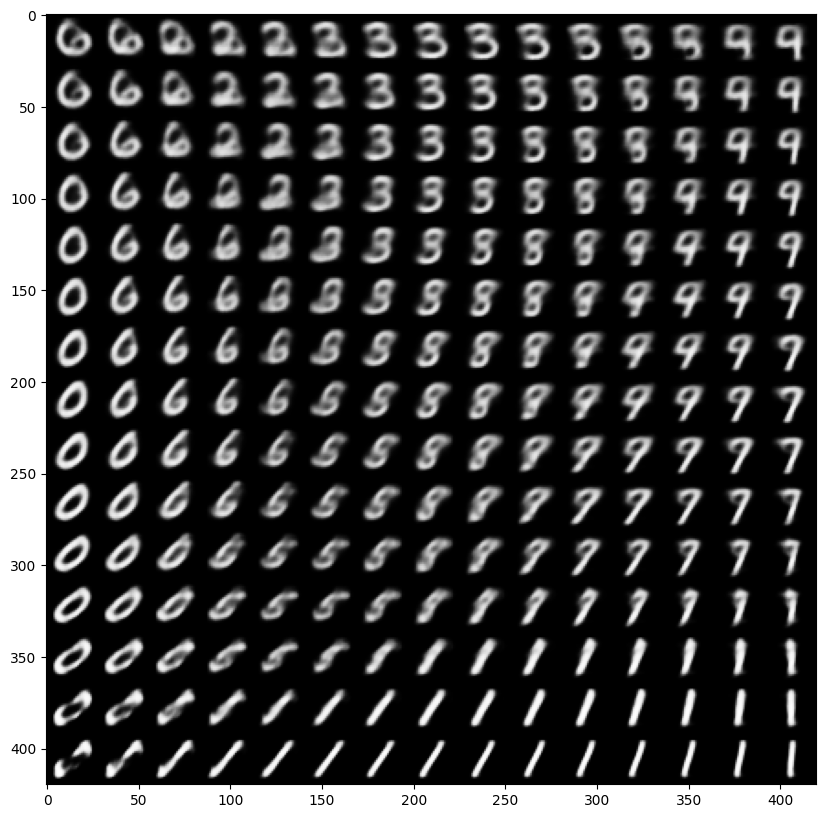

In [6]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        # get a value for each dimension of z
        z_sample = np.array([[xi, yi]])
        
        # now get the output from decoder, generating numbers 
        x_decoded = decoder.predict(z_sample, batch_size=1, verbose=0)
        
        # just grab the first one from the batch
        digit = x_decoded.reshape(digit_size, digit_size)
        
        # place into the figure
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

The grid of sampled digits shows a completely continuous distribution of the different digit classes, with one digit morphing into another 
as you follow a path through latent space. Specific directions in this space have a meaning, e.g. there is a direction for "four-ness", 
"one-ness", etc.

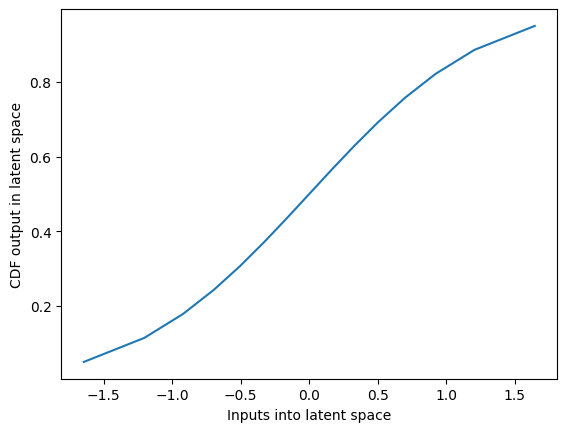

In [9]:
# This block for showing the shapes of some internal structures
# used in the code above
from scipy.stats import norm
import numpy as np
n = 15
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
output_vals = norm.cdf(grid_x, loc=0, scale=1)

plt.plot(grid_x, output_vals)
plt.xlabel('Inputs into latent space')
plt.ylabel('CDF output in latent space')
plt.show()